In [69]:
import simpy
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as st

2) Discrete Event Simulation

**DES code**:

In [3]:
class Queue:
    def __init__(self,env,n_servers,rho,mu,scheduling_type = 'FIFO', service_distribution="M"):
        self.env = env
        self.scheduling_type = scheduling_type
        self.mu = mu
        self.rho = rho
        self.lambd = rho*(n_servers*mu)
        self.cust = 0
        self.arrival_time = 0
        self.service_start_time = 0
        self.service_distribution = service_distribution

        if scheduling_type == 'FIFO':
            self.server = simpy.Resource(env, capacity=n_servers)
        elif scheduling_type == 'SJF':
            self.server = simpy.PriorityResource(env,capacity=n_servers)

    def HyperVariate(self,p, m1, m2):
        rand = np.random.uniform()
        if rand < p:
            return random.expovariate(1.0 / m1)
        else:
            return random.expovariate(1.0 / m2)

    def arrive(self, n_customers,wait_times_list):
        while self.cust < n_customers:
            yield self.env.timeout(random.expovariate(self.lambd))
            self.cust+=1
            self.env.process(self.service(wait_times_list))
    
    def service(self, wait_times_list):
        if self.service_distribution == "M":
            serving_time = random.expovariate(self.mu) 

        elif self.service_distribution == "D":
            serving_time = 1/self.mu
        
        elif self.service_distribution == "H":
            serving_time = self.HyperVariate(0.75, 1, 5)

        else:
            raise ValueError("invalid distribution")

        self.arrival_time = self.env.now

        if self.scheduling_type == 'FIFO':
            with self.server.request() as req:
                yield req
                self.service_start_time = self.env.now
                wait_times_list.append(self.service_start_time - self.arrival_time)
                yield self.env.timeout(serving_time)

        elif self.scheduling_type == 'SJF':
            with self.server.request(priority = serving_time) as req:
                yield req
                self.service_start_time = self.env.now
                wait_times_list.append(self.service_start_time - self.arrival_time)
                yield self.env.timeout(serving_time)
    
    def run_sim(self, n_customers):
        wait_times_list = []
        self.env.process(self.arrive(n_customers, wait_times_list))
        self.env.run()
        return wait_times_list
        

**Functions:**

In [29]:
def plot_conf_95(waiting_times):
    mean = np.mean(waiting_times)
    
    confidence_interval =st.t.interval(confidence=0.95, df=len(waiting_times)-1, loc=mean, scale=st.sem(waiting_times))
    yerr = np.array([[confidence_interval[0], confidence_interval[1]]])
    return mean, yerr

**Opdracht 2: n=1,2,4 en 3: SJF**

In [4]:
random.seed(3)
runs = 1000
n_customers = 500
rho = 0.8
mu = 1/2

env = simpy.Environment()

wait_total_n1 = []
wait_total_n2 = []
wait_total_n4 = []

wait_total_n1_sjf = []
wait_total_n2_sjf = []
wait_total_n4_sjf = []
for i in range(runs):
    MM1queue_fifo = Queue(env,1,rho,mu)
    MM2queue_fifo = Queue(env,2,rho,mu)
    MM4queue_fifo = Queue(env,4,rho,mu)
    
    wait_total_n1.extend(MM1queue_fifo.run_sim(n_customers))
    wait_total_n2.extend(MM2queue_fifo.run_sim(n_customers))
    wait_total_n4.extend(MM4queue_fifo.run_sim(n_customers))

    MM1queue_sjf = Queue(env,1,rho,mu, scheduling_type='SJF')
    MM2queue_sjf = Queue(env,2,rho,mu, scheduling_type='SJF')
    MM4queue_sjf = Queue(env,4,rho,mu, scheduling_type='SJF')
    
    wait_total_n1_sjf.extend(MM1queue_sjf.run_sim(n_customers))
    wait_total_n2_sjf.extend(MM2queue_sjf.run_sim(n_customers))
    wait_total_n4_sjf.extend(MM4queue_sjf.run_sim(n_customers))


Code for comparing rho's

In [67]:
# compare for different values of rho
random.seed(3)
runs = 100
n_customers = 50
mu = 1/2

env = simpy.Environment()
rhos_list = np.linspace(0.2,0.95,10)

def waiting_times_of_rhos(rhos_list, servers):
    waiting_times_of_rhos = []
    for rho in rhos_list:
        rho_temp_list = []
        for _ in range(runs):
            MM1queue_rho = Queue(env,servers,rho,mu)
            rho_temp_list.extend(MM1queue_rho.run_sim(n_customers)) # take the mean here? only append mean? or do we not want to lose data?

        waiting_times_of_rhos.append(rho_temp_list)
    return np.array(waiting_times_of_rhos)

waiting_times_of_rhos_n1 = waiting_times_of_rhos(rhos_list, 1)
waiting_times_of_rhos_n2 = waiting_times_of_rhos(rhos_list, 2)
waiting_times_of_rhos_n4 = waiting_times_of_rhos(rhos_list, 4)


[[0.00303072 0.00707552]]
[[0.01684915 0.02475967]]
[[0.01992812 0.02802825]]
[[0.04723683 0.06001191]]
[[0.07672551 0.09362927]]
[[0.12562952 0.14645989]]
[[0.16167388 0.18596331]]
[[0.25547815 0.29274605]]
[[0.36064499 0.4105915 ]]
[[0.43961707 0.49835984]]


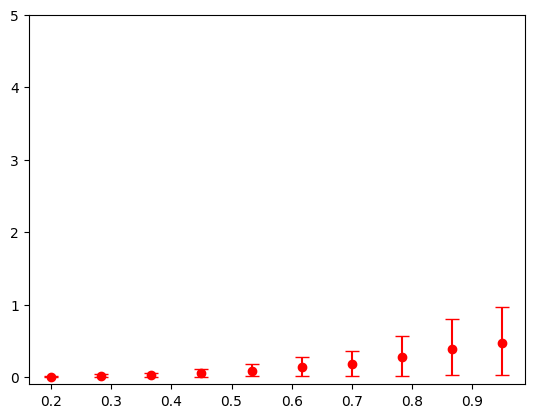

In [68]:
def rho_errorbars(waiting_times_of_rhos):
    means = []
    cis = []
    for waiting_times_run in waiting_times_of_rhos:
        mean, yerr = plot_conf_95(waiting_times_run)
        print(yerr)
        means.append(mean)
        cis.append(yerr)
    for i in range(len(rhos_list)):
        plt.errorbar(x=rhos_list[i], y=means[i], yerr=np.array(cis[i]).T, fmt='o', capsize=5, color = 'red')
    plt.ylim(-0.1,5)
    plt.show()


# rho_errorbars(waiting_times_of_rhos_n1)
# rho_errorbars(waiting_times_of_rhos_n2)
rho_errorbars(waiting_times_of_rhos_n4)




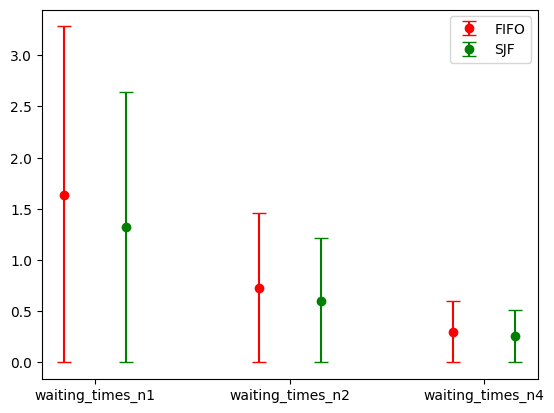

In [7]:
m1, yerr1 = plot_conf_95(wait_total_n1)
m2, yerr2 = plot_conf_95(wait_total_n2)
m4, yerr4 = plot_conf_95(wait_total_n4)

m1_sjf, yerr1_sjf = plot_conf_95(wait_total_n1_sjf)
m2_sjf, yerr2_sjf = plot_conf_95(wait_total_n2_sjf)
m4_sjf, yerr4_sjf = plot_conf_95(wait_total_n4_sjf)

plt.errorbar(x=1-0.16, y=m1, yerr=yerr1.T, fmt='o', capsize=5, label='FIFO', color = 'red')
plt.errorbar(x=1+0.16, y=m1_sjf, yerr=yerr1_sjf.T, fmt='o', capsize=5, label='SJF', color = 'green')

plt.errorbar(x=2-0.16, y=m2, yerr=yerr2.T, fmt='o', capsize=5,color = 'red')
plt.errorbar(x=2+0.16, y=m2_sjf, yerr=yerr2_sjf.T, fmt='o', capsize=5,color = 'green')

plt.errorbar(x=3-0.16, y=m4, yerr=yerr4.T, fmt='o', capsize=5,color = 'red')
plt.errorbar(x=3+0.16, y=m4_sjf, yerr=yerr4_sjf.T, fmt='o', capsize=5,color = 'green')

plt.xticks([1, 2, 3], ['waiting_times_n1', 'waiting_times_n2', 'waiting_times_n4'])
plt.legend()
plt.show()

In [8]:
print(f"For a queue with in total {n_customers} people that get in the queue with system load {rho} for {runs} days:")
print(f"the mean waiting time was {np.mean(wait_total_n1)}, with a standard deviation of {np.std(wait_total_n1)}")
print(f"the mean waiting time was {np.mean(wait_total_n2)}, with a standard deviation of {np.std(wait_total_n2)}")
print(f"the mean waiting time was {np.mean(wait_total_n4)}, with a standard deviation of {np.std(wait_total_n4)}")

print(f"the mean waiting time sjf was {np.mean(wait_total_n1_sjf )}, with a standard deviation of {np.std(wait_total_n1_sjf )}")
print(f"the mean waiting time sjf was {np.mean(wait_total_n2_sjf )}, with a standard deviation of {np.std(wait_total_n2_sjf )}")
print(f"the mean waiting time sjf was {np.mean(wait_total_n4_sjf )}, with a standard deviation of {np.std(wait_total_n4_sjf )}")


For a queue with in total 50 people that get in the queue with system load 0.8999999999999999 for 100 days:
the mean waiting time was 1.6377590520500607, with a standard deviation of 2.26352371250653
the mean waiting time was 0.7273675987929226, with a standard deviation of 1.0926169495225986
the mean waiting time was 0.2989505460756179, with a standard deviation of 0.5069620817711834
the mean waiting time sjf was 1.318021046582416, with a standard deviation of 1.6183854465546543
the mean waiting time sjf was 0.6048065647156785, with a standard deviation of 0.8177237196001762
the mean waiting time sjf was 0.25602494178487456, with a standard deviation of 0.4021811340341739


opdracht 3: plot waiting times against number of customers with 4 servers

In [9]:
random.seed(3)
runs = 10
n_customers = 5
rho = 0.8
mu = 1/2

env = simpy.Environment()


waiting_times = []

waiting_times_sjf = []
for i in range(runs):
    MM4queue_fifo = Queue(env,4,rho,mu)

    waiting_times.append(MM4queue_fifo.run_sim(n_customers))

    MM4queue_sjf = Queue(env,4,rho,mu, scheduling_type='SJF')

    waiting_times_sjf.append(MM4queue_sjf.run_sim(n_customers))

**Opdracht 4**

In [10]:
random.seed(3)
runs = 100
n_customers = 50
rho = 0.8
mu = 1/2

env = simpy.Environment()

wait_total_n1_Det = []
wait_total_n2_Det = []
wait_total_n4_Det = []

wait_total_n1_Hexp = []
wait_total_n2_Hexp = []
wait_total_n4_Hexp = []


for i in range(runs):
    MD1queue_fifo = Queue(env,1,rho,mu, service_distribution="D")
    MD2queue_fifo = Queue(env,2,rho,mu, service_distribution="D")
    MD4queue_fifo = Queue(env,4,rho,mu, service_distribution="D")
    
    wait_total_n1_Det.extend(MD1queue_fifo.run_sim(n_customers))
    wait_total_n2_Det.extend(MD2queue_fifo.run_sim(n_customers))
    wait_total_n4_Det.extend(MD4queue_fifo.run_sim(n_customers))

    MH1queue_fifo = Queue(env,1,rho,mu, service_distribution="H")
    MH2queue_fifo = Queue(env,2,rho,mu, service_distribution="H")
    MH4queue_fifo = Queue(env,4,rho,mu, service_distribution="H")
    
    wait_total_n1_Hexp.extend(MH1queue_fifo.run_sim(n_customers))
    wait_total_n2_Hexp.extend(MH2queue_fifo.run_sim(n_customers))
    wait_total_n4_Hexp.extend(MH4queue_fifo.run_sim(n_customers))




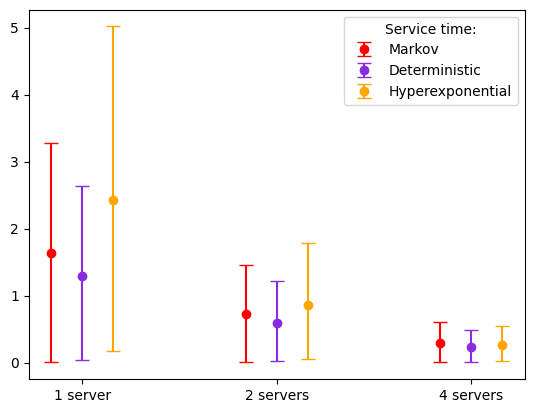

In [11]:
m1, yerr1 = plot_conf_95(wait_total_n1)
m2, yerr2 = plot_conf_95(wait_total_n2)
m4, yerr4 = plot_conf_95(wait_total_n4)

m1_sjf, yerr1_sjf = plot_conf_95(wait_total_n1_sjf)
m2_sjf, yerr2_sjf = plot_conf_95(wait_total_n2_sjf)
m4_sjf, yerr4_sjf = plot_conf_95(wait_total_n4_sjf)

m1_Det, yerr1_Det = plot_conf_95(wait_total_n1_Det)
m2_Det, yerr2_Det = plot_conf_95(wait_total_n2_Det)
m4_Det, yerr4_Det = plot_conf_95(wait_total_n4_Det)

m1_Hexp, yerr1_Hexp = plot_conf_95(wait_total_n1_Hexp)
m2_Hexp, yerr2_Hexp = plot_conf_95(wait_total_n2_Hexp)
m4_Hexp, yerr4_Hexp = plot_conf_95(wait_total_n4_Hexp)

plt.errorbar(x=1-0.16, y=m1, yerr=yerr1.T, fmt='o', capsize=5, label='Markov', color = 'red')
plt.errorbar(x=1, y=m1_Det, yerr=yerr1_Det.T, fmt='o', capsize=5, label='Deterministic', color = 'blueviolet')
plt.errorbar(x=1+0.16, y=m1_Hexp, yerr=yerr1_Hexp.T, fmt='o', capsize=5, label='Hyperexponential', color = 'orange')

plt.errorbar(x=2-0.16, y=m2, yerr=yerr2.T, fmt='o', capsize=5,color = 'red')
plt.errorbar(x=2, y=m2_Det, yerr=yerr2_Det.T, fmt='o', capsize=5,color = 'blueviolet')
plt.errorbar(x=2+0.16, y=m2_Hexp, yerr=yerr2_Hexp.T, fmt='o', capsize=5,color = 'orange')

plt.errorbar(x=3-0.16, y=m4, yerr=yerr4.T, fmt='o', capsize=5,color = 'red')
plt.errorbar(x=3, y=m4_Det, yerr=yerr4_Det.T, fmt='o', capsize=5,color = 'blueviolet')
plt.errorbar(x=3+0.16, y=m4_Hexp, yerr=yerr4_Hexp.T, fmt='o', capsize=5,color = 'orange')

plt.xticks([1, 2, 3], ['1 server', '2 servers', '4 servers'])
plt.legend(title="Service time:")
plt.show()